# Import

In [1]:
import sys
from pathlib import Path

# Definition du chemin vers notre code source local
sys.path.append(str(Path().resolve().parent))

In [ ]:
from stravalib import Client
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.utils import Bunch
from xgboost import XGBRegressor

from src.data_preprocessing import get_activity_streams, process_streams, prepare_ml_calibration_dataset
from src.gap_model import (
    calculate_normalized_efficiency, 
    fit_gap_model,
    plot_gap_curve_centroids
)

# Define

In [3]:
VERBOSE = True
SPORT_TYPES = ["TrailRun"]

# Activate API (`ONLY RUN THIS SECTION ONCE`)

In [4]:
client = Client()
url = client.authorization_url(
    client_id=157889,
    redirect_uri="http://localhost:5000/authorization",
)

if VERBOSE:
    print("Paste this URL on web browser and copy the string after 'code=...'")
    print(url)

Paste this URL on web browser and copy the string after 'code=...'
https://www.strava.com/oauth/authorize?client_id=157889&redirect_uri=http%3A%2F%2Flocalhost%3A5000%2Fauthorization&approval_prompt=auto&scope=read%2Cactivity%3Aread&response_type=code


In [5]:
token_response = client.exchange_code_for_token(
    client_id=157889, client_secret="c706246b4920e85a8244a26b5e1324d95f787bce", code="968a6a2ce7e6f0662c99e323fda84d192b4f6cf5" #COPY PASTED CODE HERE
)

STORED_ACCESS_TOKEN = token_response["access_token"]
STORED_REFRESH_TOKEN = token_response["refresh_token"]  # You will need this in 6 hours if you want to stay connected

# Full Data download and pre-processing

In [6]:
# Collect all running activity ids
client = Client(access_token=STORED_ACCESS_TOKEN)
all_activities = client.get_activities()

selected_activities = []
sport_types = []
for act in all_activities:
    if act.has_heartrate and act.sport_type in SPORT_TYPES:
        selected_activities.append(act)
        sport_types.append(act.sport_type)

In [8]:
# Download all activity streams
streams = get_activity_streams(client, selected_activities, max_streams=1000)

In [9]:
# Pre-process all activity streams
speed, elevation_gain, heartrate, sport_types = process_streams(streams, sport_types[:len(streams)], split_min_time=10)


Processing streams for activity 1/61
Successfully processed streams

Processing streams for activity 2/61
Successfully processed streams

Processing streams for activity 3/61
Successfully processed streams

Processing streams for activity 4/61
Successfully processed streams

Processing streams for activity 5/61
Successfully processed streams

Processing streams for activity 6/61
Successfully processed streams

Processing streams for activity 7/61
Successfully processed streams

Processing streams for activity 8/61
Successfully processed streams

Processing streams for activity 9/61
Successfully processed streams

Processing streams for activity 10/61
Successfully processed streams

Processing streams for activity 11/61
Successfully processed streams

Processing streams for activity 12/61
Successfully processed streams

Processing streams for activity 13/61
Successfully processed streams

Processing streams for activity 14/61
Successfully processed streams

Processing streams for activ

# Visualize the data

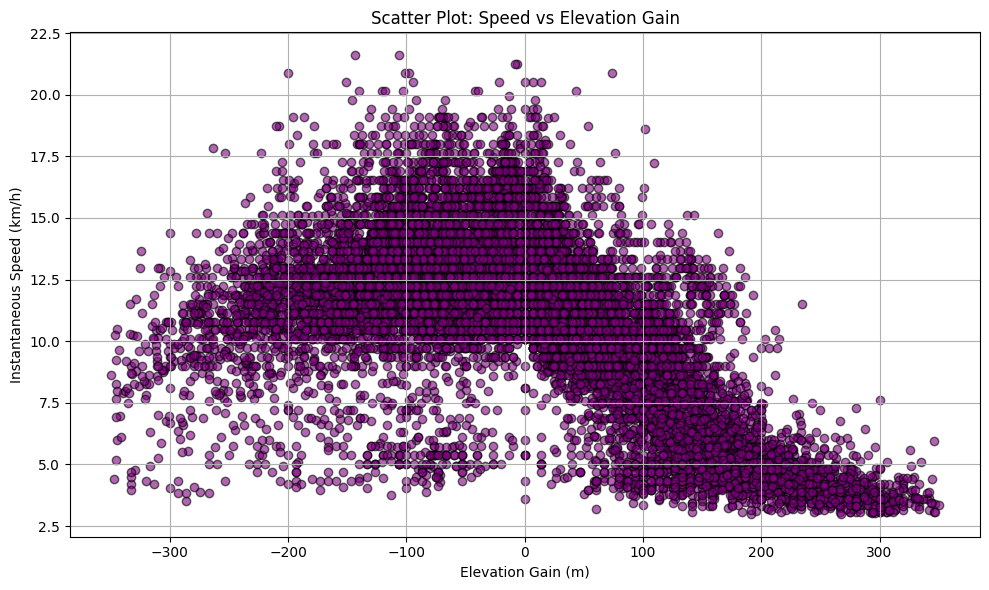

In [10]:
plt.figure(figsize=(10, 6))
plt.scatter(elevation_gain, speed, alpha=0.6, color='purple', edgecolor='k')
plt.xlabel("Elevation Gain (m)")
plt.ylabel("Instantaneous Speed (km/h)")
plt.title("Scatter Plot: Speed vs Elevation Gain")
plt.grid(True)
plt.tight_layout()
plt.show()

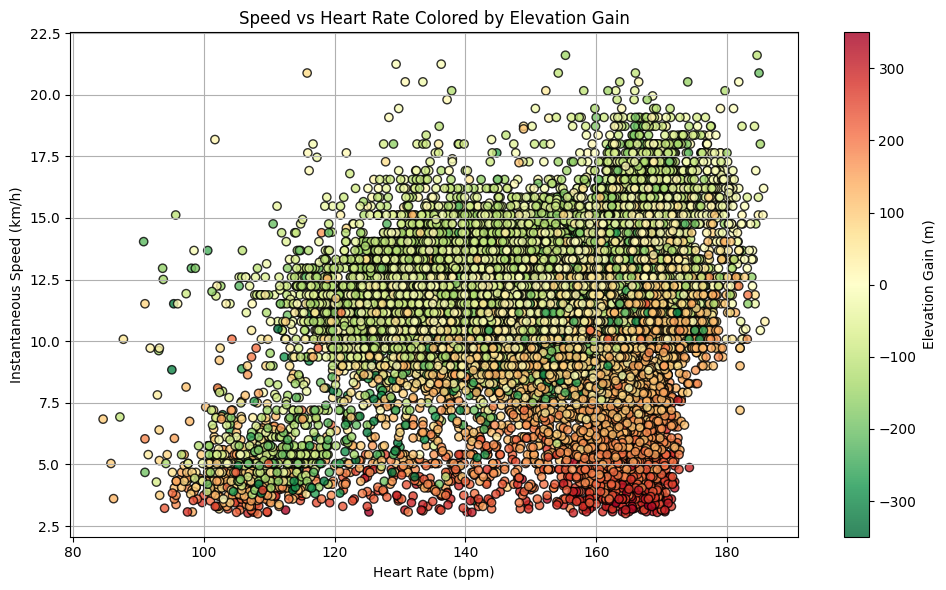

In [11]:
# Create the scatter plot
plt.figure(figsize=(10, 6))
sc = plt.scatter(
    heartrate, 
    speed,
    c=elevation_gain,
    cmap='RdYlGn_r',
    edgecolor='k',
    alpha=0.8
)

# Add colorbar to show what elevation gain the colors represent
cbar = plt.colorbar(sc)
cbar.set_label('Elevation Gain (m)')

# Labels and title
plt.xlabel("Heart Rate (bpm)")
plt.ylabel("Instantaneous Speed (km/h)")
plt.title("Speed vs Heart Rate Colored by Elevation Gain")
plt.grid(True)
plt.tight_layout()
plt.show()

# First GAP calibration method : Mimic Strava method

In [38]:
# Calculate normalized efficiencies
normalized_efficiencies = calculate_normalized_efficiency(
    speed, elevation_gain, heartrate
)

# Fit GAP model
gap_model = fit_gap_model(elevation_gain, normalized_efficiencies, min_samples_per_bucket=250)

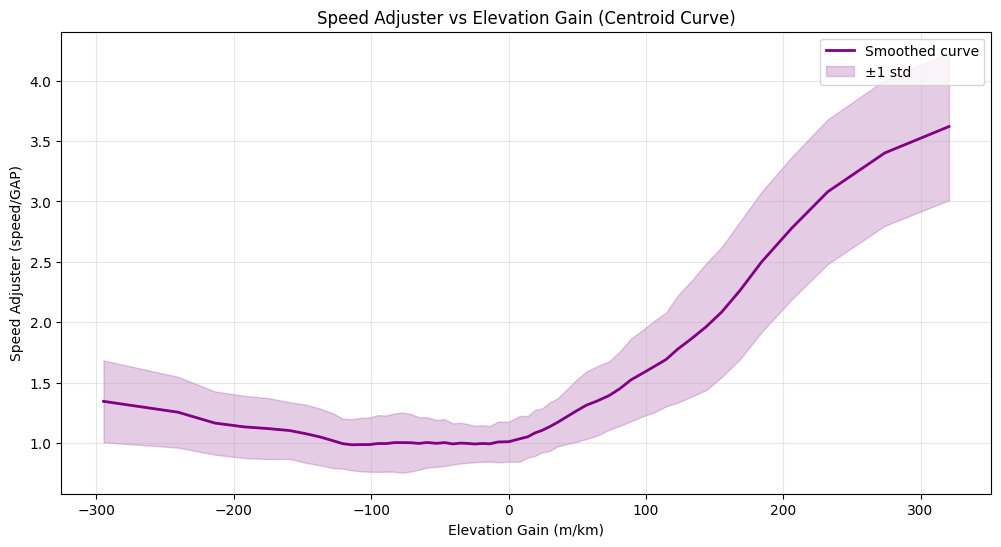

In [41]:
plot_gap_curve_centroids(gap_model, smoothing_parameter=3)

# Second GAP calibration method: XGBoost prediction model

In this section we will attempt a second method using a XGBoost prediction model.
The goal for this model will be to predict equivalent speed on flat surface (GAP) given real speed, elevation gain and heartrate. 

For this model to calibrate, we will need to build a training and testing dataset composed of:
- **X = [speed, elevation gain, heartrate]**
- **y = gap**

In order to build this dataset, we will create batches of data by matching datapoints where elevation gain is highly positive (or highly negative) to  ALL their 'close enough' points (in terms of heartrate) where elevation gain is close to 0.

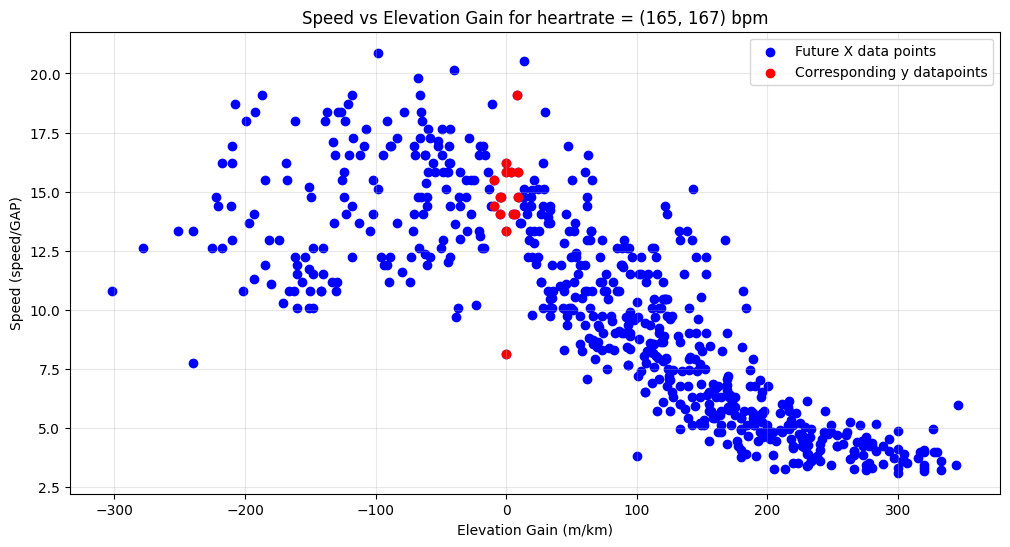

The heartrate range (165, 167) would result in 9330 data points for our model


In [64]:
# Here is a simple plot to visualize our idea

heartrate_range = (165, 167)
mask_heartrate = (heartrate >= heartrate_range[0]) * (heartrate <= heartrate_range[1])
mask_flat = (elevation_gain > -10) * (elevation_gain < 10)

plt.figure(figsize=(12, 6))
plt.scatter(elevation_gain[mask_heartrate], speed[mask_heartrate], color='b', label='Future X data points')
plt.scatter(elevation_gain[mask_heartrate * mask_flat], speed[mask_heartrate * mask_flat], color='r', label='Corresponding y datapoints')

plt.xlabel('Elevation Gain (m/km)')
plt.ylabel('Speed (speed/GAP)')
plt.title(f"Speed vs Elevation Gain for heartrate = {heartrate_range} bpm")
plt.grid(True, alpha=0.3)
plt.legend()

plt.show()

n_data_points_generated = sum(mask_heartrate) * sum(mask_heartrate * mask_flat)
print(f"The heartrate range {heartrate_range} would result in {n_data_points_generated} data points for our model")

Using this quick visualization, we can estimate that using batches of heartrate range of 3, we should have around 5000 to 10000 data points per heartrate range. Let's now apply this to all our data.

In [83]:
# Create dataset
X, y = prepare_ml_calibration_dataset(speed, elevation_gain, heartrate)

# Train/test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Fit the XGBoost model
model = XGBRegressor(objective='reg:squarederror', random_state=42)
model.fit(X_train, y_train)

# Make predictions
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

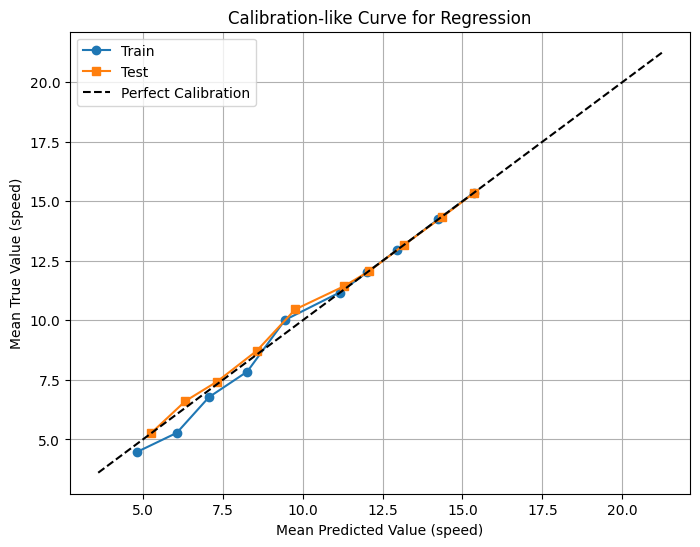

In [84]:
def calibration_regression(y_true, y_pred, n_bins=10):
    bins = np.linspace(np.min(y_pred), np.max(y_pred), n_bins + 1)
    bin_ids = np.digitize(y_pred, bins) - 1

    bin_true = []
    bin_pred = []

    for i in range(n_bins):
        bin_mask = bin_ids == i
        if np.any(bin_mask):
            bin_true.append(np.mean(y_true[bin_mask]))
            bin_pred.append(np.mean(y_pred[bin_mask]))

    return np.array(bin_pred), np.array(bin_true)

# Step 5: Plot calibration-like curve
train_pred_bins, train_true_bins = calibration_regression(y_train, y_train_pred, n_bins=10)
test_pred_bins, test_true_bins = calibration_regression(y_test, y_test_pred, n_bins=10)

plt.figure(figsize=(8, 6))
plt.plot(train_pred_bins, train_true_bins, label='Train', marker='o')
plt.plot(test_pred_bins, test_true_bins, label='Test', marker='s')
plt.plot([min(y), max(y)], [min(y), max(y)], 'k--', label='Perfect Calibration')
plt.xlabel('Mean Predicted Value (speed)')
plt.ylabel('Mean True Value (speed)')
plt.title('Calibration-like Curve for Regression')
plt.legend()
plt.grid(True)
plt.show()

The calibration curve shows no sign of overfitting as it follows the perfect calibration curve pretty well and looks close to the calibration curve for training data.

# END OF NOTEBOOK